In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json
import os
from scipy.optimize import minimize_scalar
from scipy import stats

In [24]:
dir_list = [el for el in os.listdir() if el.startswith("run_can")]
dir_list.sort(key=lambda x: os.path.getmtime(x))
run = dir_list[-1]
print(dir_list)
print("plotting run : {}".format(run))

['run_can_2023-02-14_11-32-45']
plotting run : run_can_2023-02-14_11-32-45


In [25]:
arr = np.load(run + "/posterior_first.npz")
data = np.load(run + "/data_info.npz")
filter_info = np.load(run + "/filtering_info.npz", allow_pickle=True)["arr_0"]
with open(run + "/info.json") as f:
    info = json.load(f)

In [26]:
[k for k in data.files]

['sir_data',
 'day_zero',
 'date_range_x',
 'time_domain',
 'data_grid',
 'ode_grid',
 'dense_grid',
 'train_idcs',
 'val_idcs',
 'beta_prior_mean',
 'gamma']

In [27]:
def plot_data(data):
    plt.figure(figsize=(16,4))
    plt.plot(data["sir_data"][:, 0:1], '.', label="Measurement data")
    plt.legend()
    return
def plot_sir(data, posterior, skip_first=0):
    fig, axs = plt.subplots(1,3,figsize=(16,4))

    for i, label in enumerate(["Susceptible", "Infected", "Recovered"]):
        axs[i].plot(np.exp(posterior["means"][:, (info["x_process_ordint"] + 1)*i])[::(1+int(1/info["filter_step_size"]))][skip_first:], label="Prediction")
        if i==0 : axs[i].plot(data["sir_data"][skip_first:, i], 'x', label="Data", alpha=0.2)
        axs[i].set_title(label)
        axs[i].legend()
    return

def plot_beta(posterior):
    return

def beta_link_fn(x, info, data, y_offset=0.0):
    slope = info["sigmoid_slope"]
    x_offset = -scipy.special.logit(data["beta_prior_mean"])
    return scipy.special.expit(slope * (x - x_offset)) + y_offset



## Sanity Checks

In [28]:
logS = arr["means"][:, 0]
S = np.exp(logS)
logSp = arr["means"][:, 1]
Sp = S * logSp
logI = arr["means"][:, 3]
I = np.exp(logI)
logIp = arr["means"][:, 4]
Ip = I * logIp
logR = arr["means"][:, 6]
R = np.exp(logR)
logRp = arr["means"][:, 7]
Rp = R * logRp
beta = arr["means"][:, 9]
beta_link = beta_link_fn(beta, info, data)

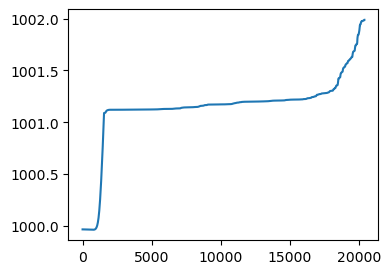

In [29]:
#Check that S + I + R = 1000 with small error (1e-2) due to diffusion noise
plt.figure(figsize=(4,3))
plt.plot(S + I + R)

In [30]:
np.mean(Rp/I), np.median(Rp/I), np.mean((Rp/I)[2500:])

(0.042173019043134856, 0.04516179672438844, 0.04514871801193931)

In [31]:
gamma = 0.049915
a = np.cov(Sp - -(S * I * beta_link/ 1000))
b = np.cov(Ip - (S * I * beta_link/ 1000 - gamma * I))
c = np.cov(Rp - gamma * I)
np.mean([a,b,c])

0.0020167806314430616

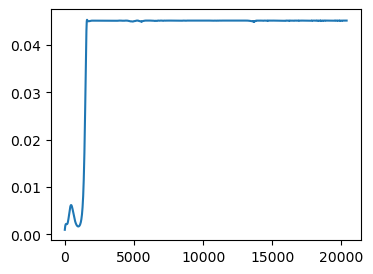

In [32]:
#Check that Rp = gamma * I, where gamma = 0.06
plt.figure(figsize=(4,3))
plt.plot(Rp / I)

array(0.00049845)

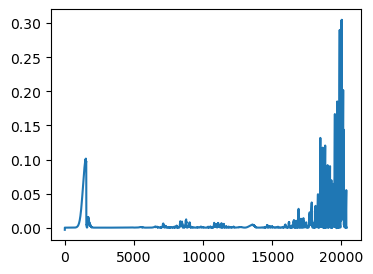

In [33]:
#Check that Sp = - S * I * beta / 1000
plt.figure(figsize=(4,3))
plt.plot(Sp + S * I * beta_link/ 1000)
np.cov(Sp + S * I * beta_link/ 1000)

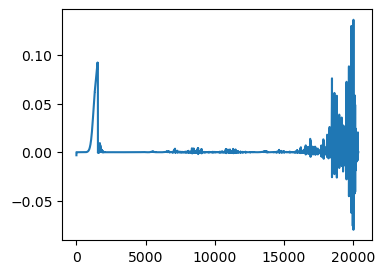

In [34]:
#Check that Ip + Sp + Rp = 0 (from Ip = -Sp - Rp)
plt.figure(figsize=(4,3))
plt.plot(Ip + Sp + Rp)

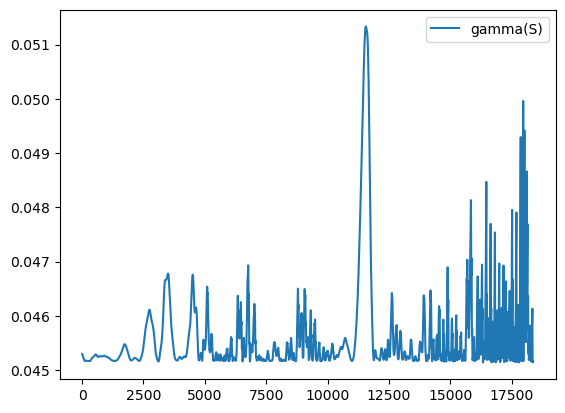

In [35]:
#gamma(S)
plt.plot((((beta_link * I * S)/1000-Ip)/I)[2000:], label="gamma(S)")
plt.legend()

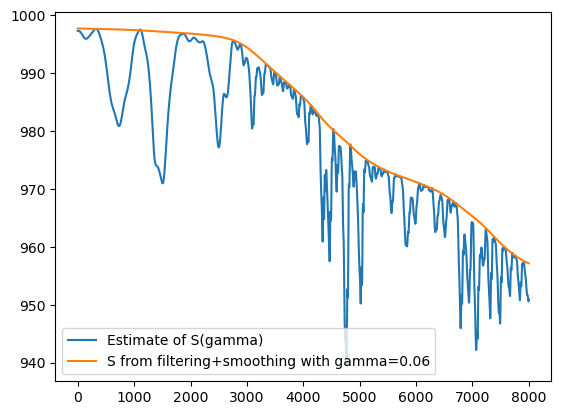

In [36]:
gamma=data["gamma"]
start_idx = 4000
end_idx = 12000
S_gamma = lambda x : (1000 * (x * I + Ip) / (beta_link * I))
plt.plot(S_gamma(gamma)[start_idx:end_idx], label="Estimate of S(gamma)")
plt.plot(S[start_idx:end_idx], label="S from filtering+smoothing with gamma=0.06")
plt.legend()

In [37]:
#Check if we are extracting the right indices when plotting. 
#If its a list of float int, we good
data["dense_grid"][::(1+int(1/info["filter_step_size"]))][:10]

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

## Auto-correlation analysis of data

In [38]:
d = data["sir_data"][:, 1]
# Mean
mean = np.mean(d)
# Variance
var = np.var(d)

# Normalized data
ndata = d - mean

acorr = np.correlate(ndata, ndata, 'full')[len(ndata)-1:] 
acorr = acorr / var / len(ndata)

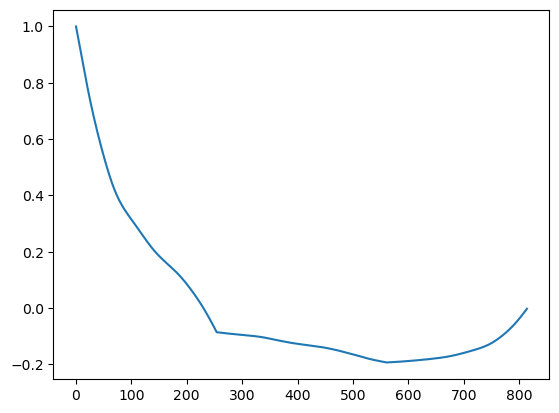

In [39]:
plt.plot(acorr)

## Plotting results

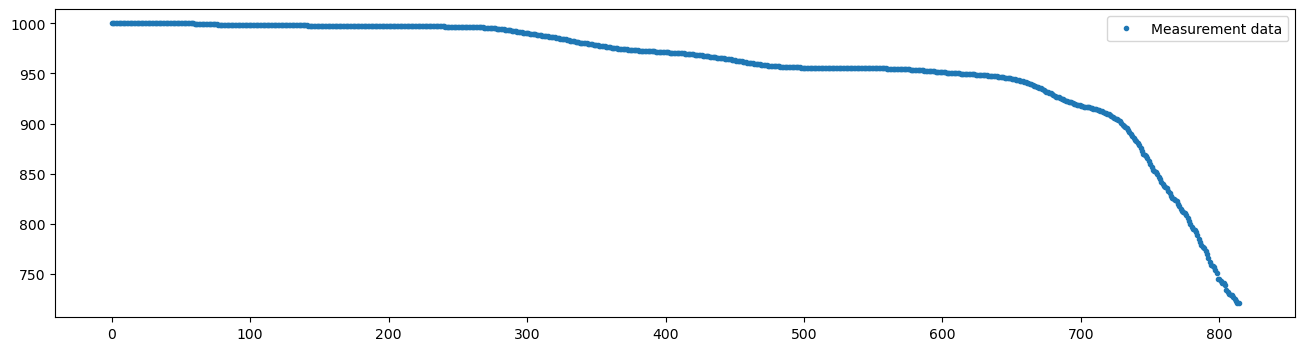

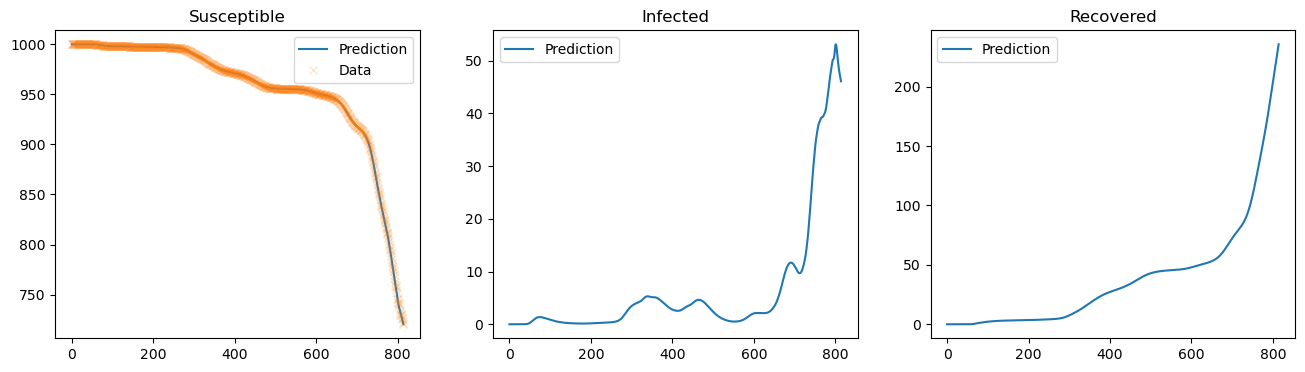

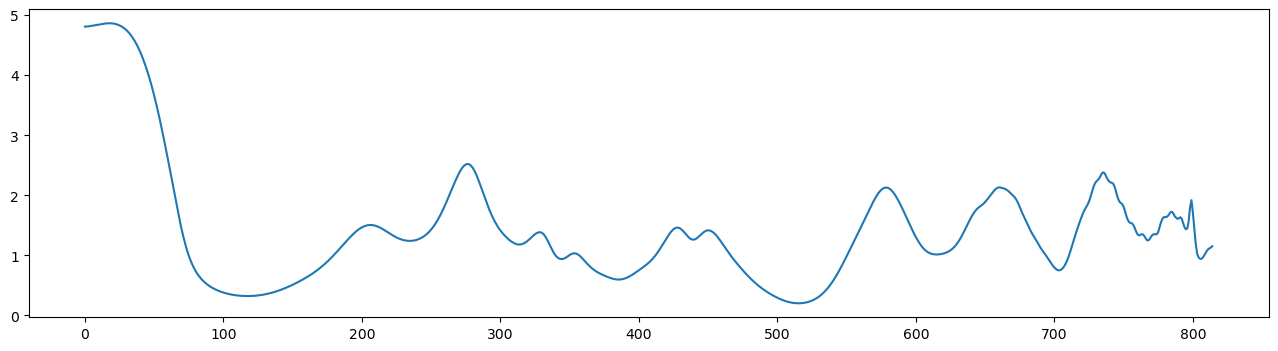

In [40]:
plot_data(data)
plot_sir(data, arr)
fig, axs = plt.subplots(1, figsize=(16,4))
axs.plot(beta_link_fn(arr["means"][:,-2][::1+int(1/info["filter_step_size"])], info, data)/data["gamma"])

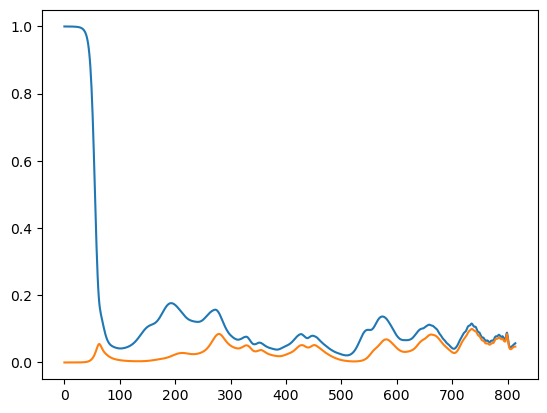

In [41]:
plt.plot(beta_link_fn(arr["means"][::25, -2] + 2*np.sqrt(arr["covs"][::25, -2, -2]), info, data))
plt.plot(beta_link_fn(arr["means"][::25, -2] - 2*np.sqrt(arr["covs"][::25, -2, -2]), info, data))